# Variational Autoencoder with PyTorch v PCA 

In this notebook I want to show two types of dimensionality reduction for tabular data: PCA and Autoencoders.

I use the wine dataset to show how Variational Autoencoder (VAE) with PyTorch on tabular data works and compare it to the classic PCA approach. I use the PCA/VAE to reduce the dimensionality of dataset, in this case don to 3 Variables (embeddings). I then plot the embeddings in a 3D graph to show how VAE is similar to a PCA but works in a non-linear way.


## Imports 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
from sklearn import preprocessing

# Any results you write to the current directory are saved as output.

/kaggle/input/wineuci/Wine.csv


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Get a quick view of the data 

In [3]:
DATA_PATH = '/kaggle/input/wineuci/Wine.csv'
pd.read_csv(DATA_PATH, sep=',', header=None, names=['Wine', 'Alcohol','Malic.acid','Ash','Acl',
                                                    'Mg', 'Phenols', 'Flavanoids','Nonflavanoid.phenols',
                                                    'Proanth','Color.int','Hue', 'OD','Proline']).head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Define Functions 

In [4]:
def load_data(path):
    # read in from csv
    df = pd.read_csv(DATA_PATH, sep=',', header=None, 
                     names=['Wine', 'Alcohol','Malic.acid','Ash','Acl','Mg', 'Phenols', 'Flavanoids','Nonflavanoid.phenols',
                            'Proanth','Color.int','Hue', 'OD','Proline'])
    # replace nan with -99
    df = df.fillna(-99)
    df_base = df.iloc[:, 1:]
    # get wine Label
    df_wine = df.iloc[:,0].values
    x = df_base.values.reshape(-1, df_base.shape[1]).astype('float32')
    # stadardize values
    standardizer = preprocessing.StandardScaler()
    x = standardizer.fit_transform(x)    
    return x, standardizer, df_wine

In [5]:
def numpyToTensor(x):
    x_train = torch.from_numpy(x).to(device)
    return x_train

# Create PCA with 3 dimensions

In [6]:
x_pca, standardizer, df_wine = load_data(DATA_PATH)

In [7]:
x_pca.shape

(178, 13)

In [8]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x_pca)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [9]:
finalDf = pd.concat([principalDf, pd.DataFrame(df_wine, columns = ['wine'])], axis = 1)
finalDf.head()

,principal component 1,principal component 2,principal component 3,wine
0,3.316751,-1.443461,-0.165739,1
1,2.209467,0.333394,-2.026457,1
2,2.516739,-1.031152,0.982820,1
3,3.757066,-2.756372,-0.176192,1
4,1.008908,-0.869832,2.026688,1


# PyTorch Autoencoder 

## Build Data Loader 

In [10]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, path):
        self.x, self.standardizer, self.wine = load_data(DATA_PATH)
        self.x = numpyToTensor(self.x)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [11]:
data_set=DataBuilder(DATA_PATH)
trainloader=DataLoader(dataset=data_set,batch_size=1024)

In [12]:
type(trainloader.dataset.x)

torch.Tensor

In [13]:
data_set.x

tensor([[ 1.5186, -0.5622,  0.2321,  ...,  0.3622,  1.8479,  1.0130],
        [ 0.2463, -0.4994, -0.8280,  ...,  0.4061,  1.1134,  0.9652],
        [ 0.1969,  0.0212,  1.1093,  ...,  0.3183,  0.7886,  1.3951],
        ...,
        [ 0.3328,  1.7447, -0.3894,  ..., -1.6121, -1.4854,  0.2806],
        [ 0.2092,  0.2277,  0.0127,  ..., -1.5683, -1.4007,  0.2965],
        [ 1.3951,  1.5832,  1.3652,  ..., -1.5244, -1.4289, -0.5952]])

## Build Model and train it

Usually VAE are used for Image processing and creating (like GANS Models). This is explained here: https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
However, we can adapt this approach to use it on tabular data. This way the Autoencoder helps us reducing dimensionality of data and also reduce noise.

In [14]:
class Autoencoder(nn.Module):
    def __init__(self,D_in,H=50,H2=12,latent_dim=3):
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        
#         # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

#         # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        
#         # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))


        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        # self.decode(z) ist später recon_batch, mu ist mu und logvar ist logvar
        return self.decode(z), mu, logvar

In [15]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    # x_recon ist der im forward im Model erstellte recon_batch, x ist der originale x Batch, mu ist mu und logvar ist logvar 
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [16]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [17]:
D_in = data_set.x.shape[1]
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
model.apply(weights_init_uniform_rule)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [18]:
loss_mse = customLoss()

## Train Model 

In [19]:
epochs = 1500
log_interval = 50
val_losses = []
train_losses = []

In [20]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
#        if batch_idx % log_interval == 0:
#            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                epoch, batch_idx * len(data), len(trainloader.dataset),
#                       100. * batch_idx / len(trainloader),
#                       loss.item() / len(data)))
    if epoch % 200 == 0:        
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

In [21]:
for epoch in range(1, epochs + 1):
    train(epoch)

====> Epoch: 200 Average loss: 10.7176
====> Epoch: 400 Average loss: 9.3970
====> Epoch: 600 Average loss: 8.7004
====> Epoch: 800 Average loss: 8.2701
====> Epoch: 1000 Average loss: 8.1218
====> Epoch: 1200 Average loss: 8.1025
====> Epoch: 1400 Average loss: 8.0290


## Evaluate 

In [22]:
standardizer = trainloader.dataset.standardizer

In [23]:
model.eval()
test_loss = 0
# no_grad() bedeutet wir nehmen die vorher berechneten Gewichte und erneuern sie nicht
with torch.no_grad():
    for i, data in enumerate(trainloader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)

In [24]:
standardizer.inverse_transform(recon_batch[65].cpu().numpy())

array([1.25304098e+01, 2.10441208e+00, 2.68674445e+00, 2.19637203e+01,
       1.11193184e+02, 2.65497684e+00, 2.64388728e+00, 3.27992886e-01,
       1.98485887e+00, 3.74176407e+00, 1.04817808e+00, 3.15698242e+00,
       6.79409912e+02], dtype=float32)

In [25]:
standardizer.inverse_transform(data[65].cpu().numpy())

array([1.237e+01, 1.210e+00, 2.560e+00, 1.810e+01, 9.800e+01, 2.420e+00,
       2.650e+00, 3.700e-01, 2.080e+00, 4.600e+00, 1.190e+00, 2.300e+00,
       6.780e+02], dtype=float32)

The recon_batch is the reconstructed data. So after putting the data through the encoder we compress the dimensions to 3 (embeddings). With these 3 representaions/embeddings of each row the decoder tries to convert it back to the original data. So basically, this recontructed row feeds itself from only three numbers.

## Get Embeddings 

In [26]:
mu_output = []
logvar_output = []

with torch.no_grad():
    for i, (data) in enumerate(trainloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)

            
            mu_tensor = mu   
            mu_output.append(mu_tensor)
            mu_result = torch.cat(mu_output, dim=0)

            logvar_tensor = logvar   
            logvar_output.append(logvar_tensor)
            logvar_result = torch.cat(logvar_output, dim=0)

In [27]:
mu_result.shape

torch.Size([178, 3])

In [28]:
mu_result[1:5,:]

tensor([[-1.3598,  0.1073, -0.0523],
        [-1.3933,  0.0987, -0.0623],
        [-1.9246, -0.0367, -0.2199],
        [-0.3321, -0.3909, -0.1294]])

These are the embeddings calculated by our VAE.

# Plot Embeddings of PCA 

In [29]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

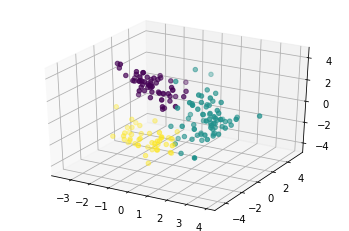

In [30]:
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
winetype = finalDf.iloc[:,3].values
zdata = finalDf.iloc[:,0].values
xdata = finalDf.iloc[:,1].values
ydata = finalDf.iloc[:,2].values
ax.scatter3D(xdata, ydata, zdata, c=winetype);

# Plot Embeddings from VAE 

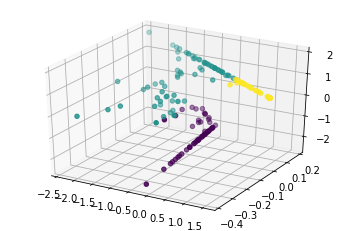

In [32]:
ax = plt.axes(projection='3d')


# Data for three-dimensional scattered points
winetype = data_set.wine
zdata = mu_result[:,0].cpu().numpy()
xdata = mu_result[:,1].cpu().numpy()
ydata = mu_result[:,2].cpu().numpy()
ax.scatter3D(xdata, ydata, zdata, c=winetype);

If there are any questions, feel free to ask.